In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import torch
from scipy.cluster import hierarchy
import shap
from tabulate import tabulate

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Feature Engineering

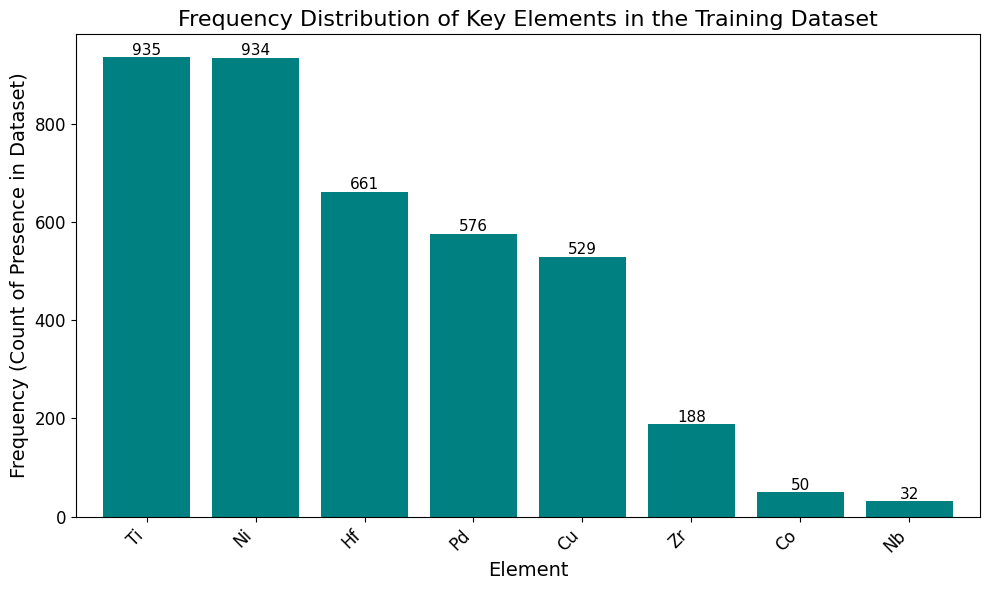

In [10]:
file_path = "/home1/nhuynh2023/Projects/Material_AF/DS_5_Ms_cleaned.csv"
data = pd.read_csv(file_path)

# Extracting key elements and processing conditions for the frequency distribution
elements = ["Ni", "Ti", "Hf", "Zr", "Cu","Co", "Pd", "Nb"]
processing_conditions = ["Homogenization_temp", "Homogenization_time"]

# Summarizing the frequency of elements and processing conditions in the dataset
element_frequencies = data[elements].apply(lambda col: (col > 0).sum())
processing_frequencies = data[processing_conditions].apply(lambda col: (col > 0).sum())

# Combine the frequencies into a single DataFrame for plotting
frequencies = pd.concat([element_frequencies, processing_frequencies], axis=0)
frequencies.index.name = "Feature"
frequencies.name = "Frequency"

filtered_frequencies = element_frequencies.sort_values(ascending=False)

# Plotting the frequency distribution with gridlines removed
plt.figure(figsize=(10, 6))
filtered_frequencies.plot(kind="bar", color="teal", width=0.8)
plt.title("Frequency Distribution of Key Elements in the Training Dataset", fontsize=16)
plt.xlabel("Element", fontsize=14)
plt.ylabel("Frequency (Count of Presence in Dataset)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(filtered_frequencies):
    plt.text(index, value + 5, str(value), ha='center', fontsize=11)  # Adding data labels

# Gridlines are fully removed
plt.gca().grid(False)
plt.tight_layout()
plt.show()

# Test with existing machine learning models

In [50]:
# Set random seed for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
file_path = "/home1/nhuynh2023/Projects/Material_AF/DS_5_Ms_cleaned.csv"
data = pd.read_csv(file_path)

# Convert specified columns to categorical
categorical_columns = ['Homogenization_time', 'Homogenization_temp']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Combine compositional features into groups
data['Group_A'] = data['Ni'] + data['Pd'] + data['Cu'] + data['Co']
data['Group_B'] = data['Ti'] + data['Hf'] + data['Zr']
data['Nb'] = data['Nb']  # Remains independent

# Drop original compositional columns
data = data.drop(columns=['Ni', 'Pd', 'Cu', 'Co', 'Ti', 'Hf', 'Zr'])

# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Define features and target variable
X = data_encoded.drop(columns=["Ms"])  # Drop the target variable
y = data_encoded["Ms"]  # Define the target variable

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (for models like SVR and GPR that are sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Using device: cuda


Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Training Artificial Neural Network (ANN)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home1/nhuynh2023/.conda/envs/GPU1/lib/python3.9/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home1/nhuynh2023/.conda/envs/GPU1/lib/python3.9/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home1/nhuynh2023/.conda/envs/GPU1/lib/python3.9/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home1/nhuynh2023/.conda/envs/GPU1/lib/python3.9/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home1/nhuynh2023/.conda/envs/GPU1/lib/python3.9/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home1/nhuynh2023/.conda/envs/GPU1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic O

Best parameters for Artificial Neural Network (ANN): {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001, 'solver': 'adam'}
Training XGBRegressor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Training SVR...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for SVR: {'C': 10, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Training Gaussian Process Regression (GPR)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Gaussian Process Regression (GPR): {'alpha': 1e-06, 'kernel__k1__length_scale': 0.5, 'kernel__k2__noise_level': 1.0}
Training Extra Trees...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Extra Trees: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training CatBoost...
Fitting 5

TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Best parameters for CatBoost: {'depth': 8, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8}
+---+-----------------------------------+------+-------+-------+
|   |               Model               |  R²  |  MAE  | RMSE  |
+---+-----------------------------------+------+-------+-------+
| 6 |            Extra Trees            | 0.82 | 23.1  | 41.48 |
| 7 |             CatBoost              | 0.8  | 25.22 | 43.96 |
| 3 |           XGBRegressor            | 0.78 | 25.78 | 46.33 |
| 1 |         Gradient Boosting         | 0.75 | 25.9  | 49.53 |
| 0 |           Random Forest           | 0.74 | 27.29 | 50.38 |
| 5 | Gaussian Process Regression (GPR) | 0.66 | 33.35 | 57.82 |
| 4 |                SVR                | 0.42 | 52.46 | 75.25 |
| 2 |  Artificial Neural Network (ANN)  | 0.25 | 65.51 | 85.97 |
+---+-----------------------------------+------+-------+-------+


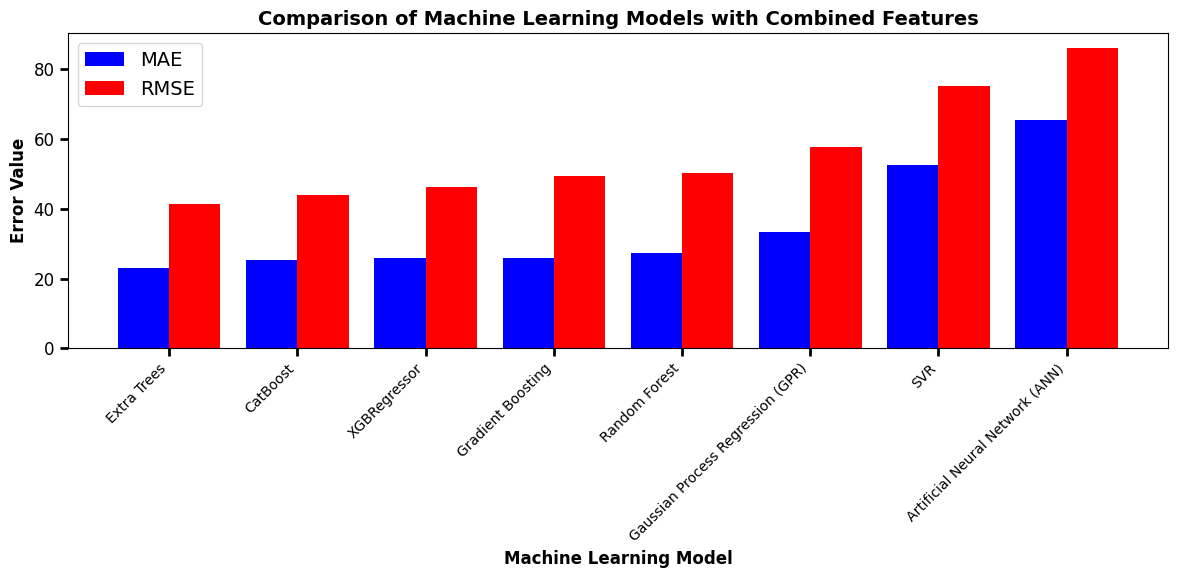

In [29]:
# Define models with expanded hyperparameter grids for tuning
models = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    },
    "Artificial Neural Network (ANN)": {
        "model": MLPRegressor(max_iter=500, random_state=42),
        "param_grid": {
            "hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
            "learning_rate_init": [0.001, 0.01],
            "alpha": [0.0001, 0.001],
            "solver": ['adam', 'sgd']
        }
    },
    "XGBRegressor": {
        "model": XGBRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    },
    "SVR": {
        "model": SVR(),
        "param_grid": {
            "kernel": ["rbf"],
            "C": [0.1, 0.5, 1, 5, 10],
            "epsilon": [0.1, 0.2],
            "gamma": ['scale', 'auto']
        }
    },
    "Gaussian Process Regression (GPR)": {
        "model": GaussianProcessRegressor(kernel=RBF(1.0) + WhiteKernel(noise_level=1.0), normalize_y=True),
        "param_grid": {
            "kernel__k1__length_scale": [0.1, 0.5, 1.0, 5.0, 10.0],
            "kernel__k2__noise_level": [0.1, 1.0],
            "alpha": [1e-6, 1e-4, 1e-2]
        }
    },
    "Extra Trees": {
        "model": ExtraTreesRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [6, 8],
            "subsample": [0.8, 1.0]
        }
    }
}

# Train and evaluate models
results = []
for name, model_info in models.items():
    print(f"Training {name}...")
    model = model_info["model"]
    param_grid = model_info.get("param_grid", {})

    # Apply hyperparameter tuning
    if param_grid:
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=5,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
            verbose=1
        )
        try:
            if name in ["SVR", "Gaussian Process Regression (GPR)"]:
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_test_scaled)
            else:
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_test)
            print(f"Best parameters for {name}: {grid_search.best_params_}")
        except Exception as e:
            print(f"Error tuning {name}: {e}")
            # Fall back to default model
            if name in ["SVR", "Gaussian Process Regression (GPR)"]:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
    else:
        # For models without tuning (should not occur with current setup)
        if name in ["SVR", "Gaussian Process Regression (GPR)"]:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "R²": r2, "MAE": mae, "RMSE": rmse})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="MAE")
results_df_sorted = results_df.sort_values(by="MAE")
results_df_sorted = results_df_sorted.round({"R²": 2, "MAE": 2, "RMSE": 2})

print(tabulate(results_df_sorted, headers="keys", tablefmt="pretty"))

# Plotting the performance of different models
plt.figure(figsize=(12, 6))
x_labels = results_df_sorted["Model"]
x = np.arange(len(x_labels))

plt.bar(x, results_df_sorted["MAE"], width=0.4, label="MAE", color="blue")
plt.bar(x + 0.4, results_df_sorted["RMSE"], width=0.4, label="RMSE", color="red")

plt.xticks(x + 0.2, x_labels, rotation=45, ha="right", fontsize=10)
plt.xlabel("Machine Learning Model", fontsize=12)
plt.ylabel("Error Value", fontsize=12)
plt.title("Comparison of Machine Learning Models with Combined Features", fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison_plot_combined_features.png")
plt.show()

# Examing Correlation

In [2]:
# Set random seed for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
file_path = "/home1/nhuynh2023/Projects/Material_AF/DS_5_Ms_cleaned.csv"
data = pd.read_csv(file_path)

Using device: cuda


Highly correlated feature pairs (|corr| > 0.8, pre-encoding, including Ms): [('Ni', 'Pd'), ('Ni', 'Heat of fusion'), ('Ni', 'Vicker Hardness'), ('Ti', 'Hf'), ('Ti', 'AM'), ('Ti', 'X'), ('Ti', 'Delta'), ('Ti', 'Heat of vaporization'), ('Ti', 'Boiling point'), ('Ti', 'Density'), ('Hf', 'AM'), ('Hf', 'Tm'), ('Hf', 'Delta'), ('Hf', 'CV'), ('Hf', 'Heat of fusion'), ('Hf', 'Heat of vaporization'), ('Hf', 'Boiling point'), ('Hf', 'Density'), ('Hf', 'Vicker Hardness'), ('Cu', 'Thermal conductivity'), ('Cu', 'Electrical conductivity'), ('Pd', 'X'), ('Pd', 'Hmix'), ('Pd', 'Delta'), ('Homogenization_temp', 'Homogenization_time'), ('AM', 'CV'), ('AM', 'Heat of vaporization'), ('AM', 'Boiling point'), ('AM', 'Density'), ('BM', 'OMEGA'), ('Tm', 'CV'), ('Tm', 'Heat of fusion'), ('Tm', 'Heat of vaporization'), ('Tm', 'Boiling point'), ('Tm', 'Vicker Hardness'), ('X', 'Delta'), ('X', 'Ionization energy'), ('X', 'Heat of vaporization'), ('X', 'Boiling point'), ('X', 'Vicker Hardness'), ('Hmix', 'OMEGA')

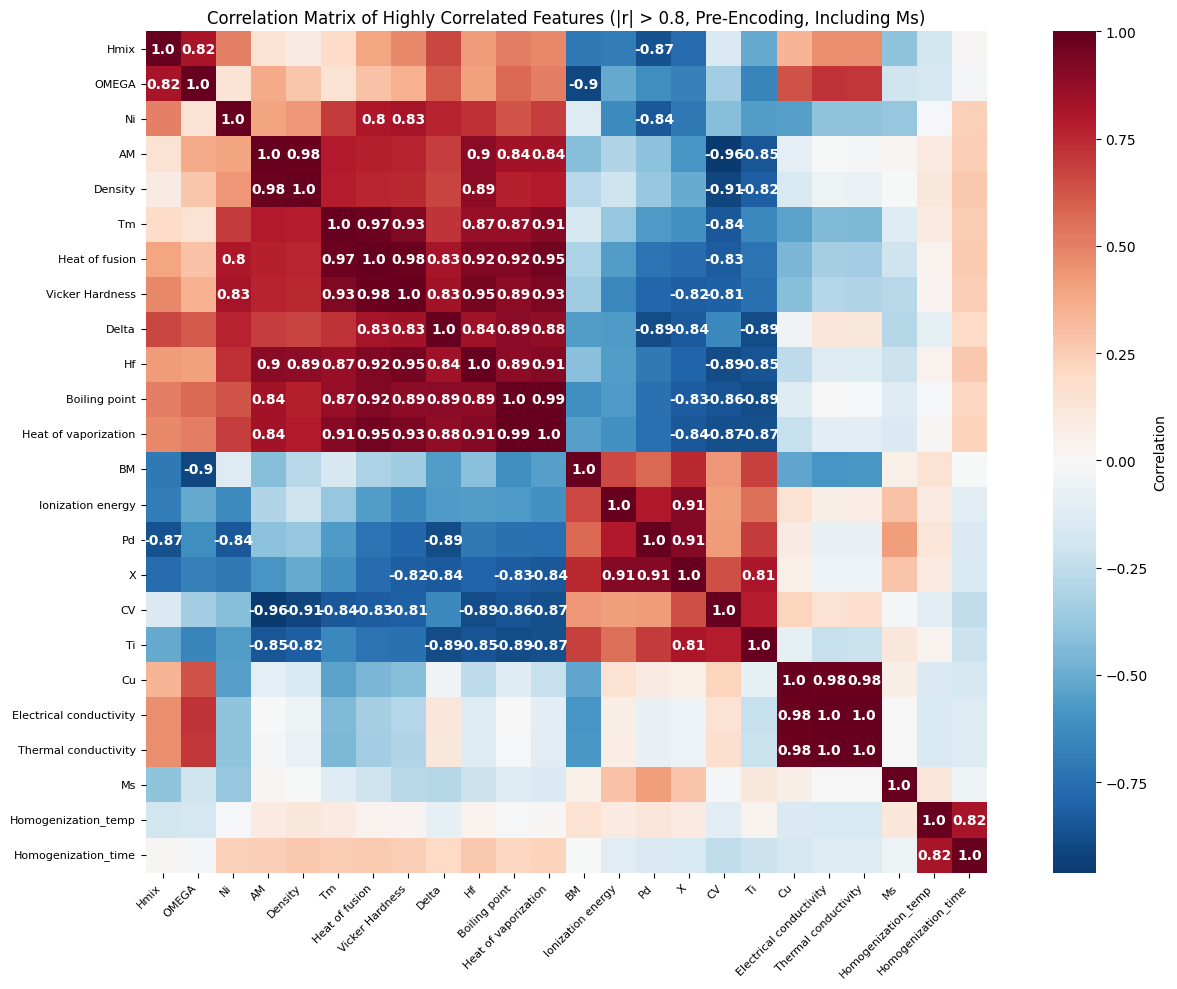

In [5]:
# Prepare data for correlation analysis (before one-hot encoding)
data_for_corr = data.copy()
# Label encode categorical columns for correlation analysis
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_for_corr[col] = le.fit_transform(data_for_corr[col])
    label_encoders[col] = le
    
# Feature correlation analysis
correlation_matrix = data_for_corr.corr()
    
# Identify highly correlated features (|correlation| > 0.8) in pre-encoding data
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
                   for i, j in zip(*high_corr) if i != j and i < j]
print("Highly correlated feature pairs (|corr| > 0.8, pre-encoding):", high_corr_pairs)

# Identify highly correlated features (|correlation| > 0.8) in pre-encoding data, including correlations with 'Ms'
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
                   for i, j in zip(*high_corr) if i != j and i < j]
print("Highly correlated feature pairs (|corr| > 0.8, pre-encoding, including Ms):", high_corr_pairs)

# Select features involved in high correlations, and explicitly include 'Ms' regardless of its correlation
high_corr_features = sorted(set([pair[0] for pair in high_corr_pairs] + [pair[1] for pair in high_corr_pairs]))
if 'Ms' not in high_corr_features:
    high_corr_features.append('Ms')  # Ensure 'Ms' is included in the high-correlation heatmap
if high_corr_features:  # Proceed only if there are features to plot
    high_corr_matrix = correlation_matrix.loc[high_corr_features, high_corr_features]

    # Hierarchical clustering to reorder high-correlation features
    linkage = hierarchy.linkage(high_corr_matrix, method='average')
    dendro = hierarchy.dendrogram(linkage, no_plot=True)
    reordered_indices = dendro['leaves']
    reordered_high_corr_matrix = high_corr_matrix.iloc[reordered_indices, reordered_indices]

    # Create annotation matrix for |r| > 0.8
    annot_matrix = np.where(
        np.abs(reordered_high_corr_matrix) > 0.8,
        reordered_high_corr_matrix.round(2).astype(str),
        ''
    )

    # Plot heatmap for highly correlated features, now including 'Ms'
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        reordered_high_corr_matrix, 
        annot=annot_matrix, 
        fmt='', 
        cmap='RdBu_r', 
        center=0, 
        cbar_kws={'label': 'Correlation'},
        xticklabels=reordered_high_corr_matrix.columns,
        yticklabels=reordered_high_corr_matrix.index,
        annot_kws={'size': 10, 'weight': 'bold'},
        square=True
    )
    plt.title('Correlation Matrix of Highly Correlated Features (|r| > 0.8, Pre-Encoding, Including Ms)')
    plt.xticks(fontsize=8, rotation=45, ha='right')
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig('correlation_matrix_high_corr_with_ms.png')
    plt.show()
    plt.close()
else:
    print("No features with |correlation| > 0.8 found; skipping high-correlation heatmap.")

## Prepare data

In [2]:
# Set random seed for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
file_path = "/home1/nhuynh2023/Projects/Material_AF/DS_5_Ms_cleaned.csv"
data = pd.read_csv(file_path)

# Convert specified columns to categorical
categorical_columns = ['Homogenization_time', 'Homogenization_temp']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Combine compositional features into groups
data['Group_A'] = data['Ni'] + data['Pd'] + data['Cu'] + data['Co']
data['Group_B'] = data['Ti'] + data['Hf'] + data['Zr']
data['Nb'] = data['Nb']  # Remains independent

# Drop original compositional columns
data = data.drop(columns=['Ni', 'Pd', 'Cu', 'Co', 'Ti', 'Hf', 'Zr'])

# Separate features and target
X = data_encoded.drop('Ms', axis=1)
y = data_encoded['Ms']

Using device: cuda


## Model architecture

In [3]:
# Standardize features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_scaled, test_size=0.2, random_state=42)

# Select features for attention branch (compositional features)
attention_features = ['Ni', 'Ti', 'Hf', 'Zr', 'Cu', 'Pd', 'Co', 'Nb']
attention_indices = [X.columns.get_loc(col) for col in attention_features]
X_train_attention = X_train.iloc[:, attention_indices].values
X_test_attention = X_test.iloc[:, attention_indices].values

# Add small random noise to training features for augmentation
X_train_attention += np.random.normal(0, 0.01, X_train_attention.shape)
X_train += np.random.normal(0, 0.01, X_train.shape)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
X_train_attention_tensor = torch.tensor(X_train_attention, dtype=torch.float32).to(device)
X_test_attention_tensor = torch.tensor(X_test_attention, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_attention_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_attention_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# Define Self-Attention Layer
class AttentionBranch(nn.Module):
    def __init__(self, input_dim, d_model=32, dropout=0.3):
        super(AttentionBranch, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=2, dropout=dropout)
        self.fc = nn.Linear(d_model, 32)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)  # (1, batch_size, d_model)
        attn_output, _ = self.attention(x, x, x)
        x = self.norm(x + self.dropout(attn_output))  # Residual connection
        x = x.squeeze(0)
        x = self.fc(x)
        return x

# Define the Deep Fusion model
class DeepFusion(nn.Module):
    def __init__(self, input_dim, attention_input_dim):
        super(DeepFusion, self).__init__()
        
        # Dense Branch with residual connection
        self.dense1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.dense2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.dense3 = nn.Linear(128, 32)
        
        # Attention Branch for compositional features
        self.attention = AttentionBranch(attention_input_dim)
        
        # Combined layers
        self.combined = nn.Sequential(
            nn.Linear(32 + 32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, x_attention):
        # Dense branch with residual connection
        x1 = self.dense1(x)
        x2 = self.dense2(x1)
        x3 = self.dense3(x2)
        dense_out = x3 + nn.Linear(256, 32).to(device)(x1)  # Residual connection
        
        # Attention branch
        attention_out = self.attention(x_attention)
        
        # Concatenate outputs
        combined = torch.cat((dense_out, attention_out), dim=1)
        out = self.combined(combined)
        return out

In [5]:
# Function to plot error histogram and cumulative histogram
def plot_error_histogram(errors, mae, title, filename, output_dir):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # Define custom bin edges
    bin_edges = np.concatenate(([0, 10], np.arange(15, 105, 5)))
    x_ticks = np.concatenate(([0, 10], np.arange(15, 105, 5)))
    
    # Plot histogram
    n, bins, patches = ax1.hist(errors, bins=bin_edges, color='#0343df', 
                                alpha=0.5, edgecolor='black', rwidth=0.8, label='Error Distribution')
    
    # Annotate bars with counts
    for rect in patches:
        height = rect.get_height()
        if height > 0:
            ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{int(height)}', 
                     ha='center', va='bottom', color='purple', fontweight='bold', fontsize=12)
    
    # Plot cumulative histogram
    n_cumulative = np.cumsum(n)
    ax2 = ax1.twinx()
    bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2
    ax2.plot(bin_centers, n_cumulative, color='r', marker='o', linestyle='-', label='Cumulative Count')
    
    # Plot MAE line
    ax1.axvline(mae, color='green', linestyle='--', label=f'MAE: {mae:.2f}°C')
    
    # Set labels and styles
    ax1.set_xlabel('Prediction Error (°C)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Count', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Cumulative Count', fontweight='bold', fontsize=14)
    
    ax1.set_xticks(x_ticks)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, ax1.get_ylim()[1] + 5)
    ax1.grid(False, axis='y')
    
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
    for spine in ax2.spines.values():
        spine.set_linewidth(2)
    ax1.tick_params(axis='both', width=2, length=6, labelsize=14)
    ax2.tick_params(axis='both', width=2, length=6, labelsize=14)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(title, fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()

# Updated training loop with early stopping, lowest MAE model saving, and best model evaluation
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=500, early_stopping_patience=50, output_dir=None, fold=None):
    model.train()
    train_losses = []
    train_maes = []
    lrs = []
    best_train_loss = float('inf')
    best_train_mae = float('inf')
    patience_counter = 0
    delta = 5e-5  # Minimum improvement threshold for early stopping
    best_model_state = None

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        train_predictions = []
        train_actuals = []
        for inputs, inputs_attention, targets in train_loader:
            inputs, inputs_attention, targets = inputs.to(device), inputs_attention.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, inputs_attention)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            train_predictions.append(outputs.cpu().detach().numpy())
            train_actuals.append(targets.cpu().detach().numpy())

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Compute train MAE
        train_predictions = np.concatenate(train_predictions)
        train_actuals = np.concatenate(train_actuals)
        train_predictions_orig = scaler_y.inverse_transform(train_predictions)
        train_actuals_orig = scaler_y.inverse_transform(train_actuals)
        train_mae = mean_absolute_error(train_actuals_orig, train_predictions_orig)
        train_maes.append(train_mae)

        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        # Save model with lowest MAE
        if train_mae < best_train_mae:
            best_train_mae = train_mae
            best_model_state = model.state_dict()

        # Early stopping based on training loss
        if epoch_train_loss < best_train_loss - delta:
            best_train_loss = epoch_train_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        # Learning rate warmup
        if epoch < warmup_epochs:
            lr_scale = (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.002 * lr_scale
        else:
            scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train MAE: {train_mae:.4f}')

    # Load the model with the lowest MAE before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), os.path.join(output_dir, f'deep_fusion_model_{"fold_" + str(fold) if fold else "full"}.pth'))

    # Plot training diagnostics
    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots()

    # Left axis: Loss and MAE
    ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    ax1.plot(train_maes, label='Train MAE (°C)', color='orange', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss / MAE (°C)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Right axis: Learning rate
    ax2 = ax1.twinx()
    ax2.plot(lrs, label='Learning Rate', color='purple', linewidth=2)
    ax2.set_ylabel('Learning Rate')
    ax2.legend(loc='upper right')

    plt.title(f'Training Diagnostics {"Fold " + str(fold) if fold else "Full Dataset"}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'training_diagnostics_{"fold_" + str(fold) if fold else "full"}.png'))
    plt.close()

    return train_losses, train_maes, lrs, best_train_mae

# Evaluate model
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, inputs_attention, targets in test_loader:
            inputs, inputs_attention, targets = inputs.to(device), inputs_attention.to(device), targets.to(device)
            outputs = model(inputs, inputs_attention)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    predictions_orig = scaler_y.inverse_transform(predictions)
    actuals_orig = scaler_y.inverse_transform(actuals)
    
    mae = mean_absolute_error(actuals_orig, predictions_orig)
    r2 = r2_score(actuals_orig, predictions_orig)
    
    return test_loss, mae, r2, predictions_orig, actuals_orig

In [7]:
# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
attention_input_dim = len(attention_features)
model = DeepFusion(input_dim, attention_input_dim).to(device)
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-6)

# Learning rate warmup
warmup_epochs = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500 - warmup_epochs)

# Cross-validation with early stopping and lowest MAE model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae, cv_r2 = [], []
fold_models = []
best_train_maes = []  # Track best training MAEs for each fold

# Create output directory for model and graph saves
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
data_dir = f'/home1/nhuynh2023/Projects/Material_Ms/data/Ms/{timestamp}'
os.makedirs(data_dir, exist_ok=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled_df)):
    print(f'Fold {fold + 1}/5')
    X_train_fold = X_scaled_df.iloc[train_idx]
    y_train_fold = y_scaled[train_idx]
    X_val_fold = X_scaled_df.iloc[val_idx]
    y_val_fold = y_scaled[val_idx]
    
    X_train_attention_fold = X_train_fold.iloc[:, attention_indices].values
    X_val_attention_fold = X_val_fold.iloc[:, attention_indices].values
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_fold.values, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val_fold.values, dtype=torch.float32).to(device)
    X_train_attention_tensor = torch.tensor(X_train_attention_fold, dtype=torch.float32).to(device)
    X_val_attention_tensor = torch.tensor(X_val_attention_fold, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1).to(device)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1).to(device)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, X_train_attention_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, X_val_attention_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # Initialize model
    model = DeepFusion(input_dim, attention_input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500 - warmup_epochs)
    
    # Train with early stopping and lowest MAE model saving
    train_losses, train_maes, lrs, best_train_mae = train_model(
        model, train_loader, criterion, optimizer, scheduler,
        num_epochs=500, early_stopping_patience=50, output_dir=data_dir, fold=fold+1
    )
    
    # Evaluate using the best model (already loaded in train_model)
    _, val_mae, val_r2, _, _ = evaluate_model(model, val_loader, criterion, scaler_y)
    cv_mae.append(val_mae)
    cv_r2.append(val_r2)
    fold_models.append(model)
    best_train_maes.append(best_train_mae)
    print(f'Fold {fold + 1} MAE: {val_mae:.4f}, R^2: {val_r2:.4f}')

print(f'Cross-Validation MAE: {np.mean(cv_mae):.4f} ± {np.std(cv_mae):.4f}')
print(f'Cross-Validation R^2: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}')

# Ensemble prediction on test set using lowest MAE models
test_predictions = []
for model in fold_models:
    _, _, _, preds, _ = evaluate_model(model, test_loader, criterion, scaler_y)
    test_predictions.append(preds)
ensemble_preds = np.mean(test_predictions, axis=0)
ensemble_actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1))

ensemble_test_mae = mean_absolute_error(ensemble_actuals, ensemble_preds)
ensemble_test_r2 = r2_score(ensemble_actuals, ensemble_preds)
print(f'Ensemble Test MAE: {ensemble_test_mae:.4f}')
print(f'Ensemble Test R^2: {ensemble_test_r2:.4f}')

# Final training on full dataset with early stopping and lowest MAE model
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model = DeepFusion(input_dim, attention_input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500 - warmup_epochs)

# Train with early stopping and lowest MAE model saving
train_losses, train_maes, lrs, best_train_mae = train_model(
    model, train_loader, criterion, optimizer, scheduler,
    num_epochs=500, early_stopping_patience=50, output_dir=data_dir
)
test_loss, test_mae, test_r2, y_pred, y_true = evaluate_model(model, test_loader, criterion, scaler_y)

print(f'Full Dataset Test Loss: {test_loss:.4f}')
print(f'Full Dataset Test MAE: {test_mae:.4f}')
print(f'Full Dataset Test R^2: {test_r2:.4f}')

Fold 1/5
Epoch [10/500], Train Loss: 0.1728, Train MAE: 42.3597
Epoch [20/500], Train Loss: 0.1460, Train MAE: 37.2215
Epoch [30/500], Train Loss: 0.1334, Train MAE: 35.7479
Epoch [40/500], Train Loss: 0.1169, Train MAE: 32.7797
Epoch [50/500], Train Loss: 0.1206, Train MAE: 33.4120
Epoch [60/500], Train Loss: 0.1069, Train MAE: 31.3795
Epoch [70/500], Train Loss: 0.1055, Train MAE: 30.8534
Epoch [80/500], Train Loss: 0.0968, Train MAE: 30.2527
Epoch [90/500], Train Loss: 0.0956, Train MAE: 29.4137
Epoch [100/500], Train Loss: 0.0899, Train MAE: 28.4949
Epoch [110/500], Train Loss: 0.0956, Train MAE: 29.6362
Epoch [120/500], Train Loss: 0.0853, Train MAE: 27.8547
Epoch [130/500], Train Loss: 0.0798, Train MAE: 26.4867
Epoch [140/500], Train Loss: 0.0896, Train MAE: 28.5604
Epoch [150/500], Train Loss: 0.0904, Train MAE: 28.3406
Epoch [160/500], Train Loss: 0.0836, Train MAE: 27.2537
Epoch [170/500], Train Loss: 0.0857, Train MAE: 27.6730
Epoch [180/500], Train Loss: 0.0815, Train MAE: 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [45]:
def calculate_rmse(model, test_loader, scaler_y):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, inputs_attention, targets in test_loader:
            inputs, inputs_attention, targets = inputs.to(device), inputs_attention.to(device), targets.to(device)
            outputs = model(inputs, inputs_attention)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    # Inverse transform predictions and actuals to original scale
    predictions_orig = scaler_y.inverse_transform(predictions)
    actuals_orig = scaler_y.inverse_transform(actuals)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals_orig, predictions_orig))
    
    return predictions_orig, actuals_orig, rmse

def get_predictions(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, inputs_attention, targets in test_loader:
            inputs, inputs_attention = inputs.to(device), inputs_attention.to(device)
            outputs = model(inputs, inputs_attention)
            predictions.append(outputs.cpu().numpy())
    return np.concatenate(predictions)

# Collect predictions from all fold models
test_predictions = []
for fold, model in enumerate(fold_models, 1):
    print(f"Making predictions with model for fold {fold}...")
    fold_preds = get_predictions(model, test_loader)
    test_predictions.append(fold_preds)

# Compute ensemble predictions by averaging across folds
ensemble_preds = np.mean(test_predictions, axis=0)

# Inverse transform predictions and actuals to original scale
ensemble_preds_orig = scaler_y.inverse_transform(ensemble_preds)
ensemble_actuals_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, and R² for the ensemble
ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actuals_orig, ensemble_preds_orig))

print(f'Ensemble Test RMSE: {ensemble_rmse:.4f}')

predictions, actuals, rmse = calculate_rmse(model, test_loader, scaler_y)
print(f'Test RMSE: {rmse:.4f}')

Making predictions with model for fold 1...
Making predictions with model for fold 2...
Making predictions with model for fold 3...
Making predictions with model for fold 4...
Making predictions with model for fold 5...
Ensemble Test RMSE: 27.2330
Test RMSE: 26.3994


# Visualization

In [7]:
# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
attention_input_dim = len(attention_features)
criterion = nn.HuberLoss(delta=1.0)

# Final training on full dataset with early stopping and lowest MAE model
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
data_dir = "/home1/nhuynh2023/Projects/Material_AF/data/Ms/17.22_2025-04-18_18-16-11/"
model = DeepFusion(input_dim, attention_input_dim).to(device)
model.load_state_dict(torch.load(data_dir+"deep_fusion_model_full.pth"))
model.eval()
test_loss, test_mae, test_r2, y_pred, y_true = evaluate_model(model, test_loader, criterion, scaler_y)

fold_models = []
num_folds = 5
for fold in range(1, num_folds + 1):
    model = DeepFusion(input_dim, attention_input_dim).to(device)
    model_path = os.path.join(data_dir, f"deep_fusion_model_fold_{fold}.pth")
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        model.eval()
        fold_models.append(model)
        print(f"Loaded model for fold {fold} from {model_path}")
    else:
        print(f"Model file for fold {fold} not found at {model_path}")
        raise FileNotFoundError(f"Model file for fold {fold} not found")

# Ensemble prediction on test set using lowest MAE models
test_predictions = []
for model in fold_models:
    _, _, _, preds, _ = evaluate_model(model, test_loader, criterion, scaler_y)
    test_predictions.append(preds)
ensemble_preds = np.mean(test_predictions, axis=0)
ensemble_actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1))

Loaded model for fold 1 from /home1/nhuynh2023/Projects/Material_AF/data/Ms/17.22_2025-04-18_18-16-11/deep_fusion_model_fold_1.pth
Loaded model for fold 2 from /home1/nhuynh2023/Projects/Material_AF/data/Ms/17.22_2025-04-18_18-16-11/deep_fusion_model_fold_2.pth
Loaded model for fold 3 from /home1/nhuynh2023/Projects/Material_AF/data/Ms/17.22_2025-04-18_18-16-11/deep_fusion_model_fold_3.pth
Loaded model for fold 4 from /home1/nhuynh2023/Projects/Material_AF/data/Ms/17.22_2025-04-18_18-16-11/deep_fusion_model_fold_4.pth
Loaded model for fold 5 from /home1/nhuynh2023/Projects/Material_AF/data/Ms/17.22_2025-04-18_18-16-11/deep_fusion_model_fold_5.pth


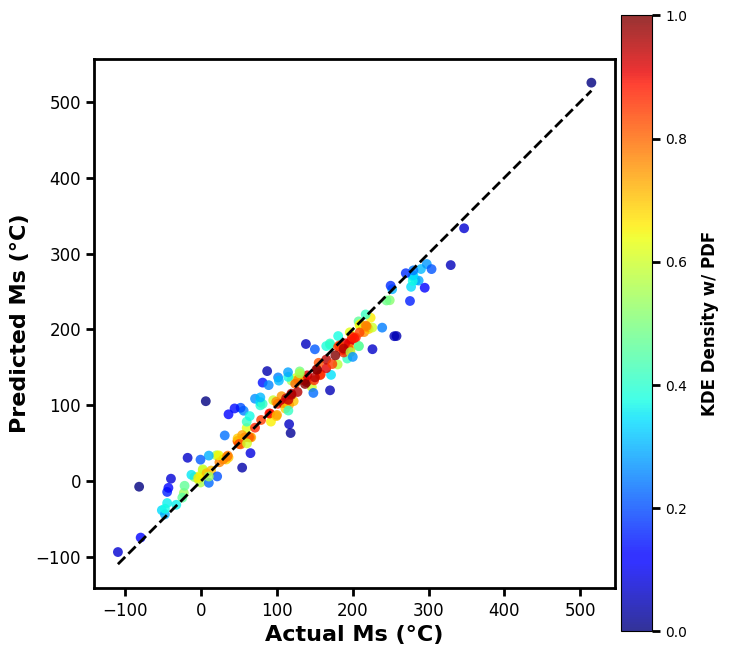

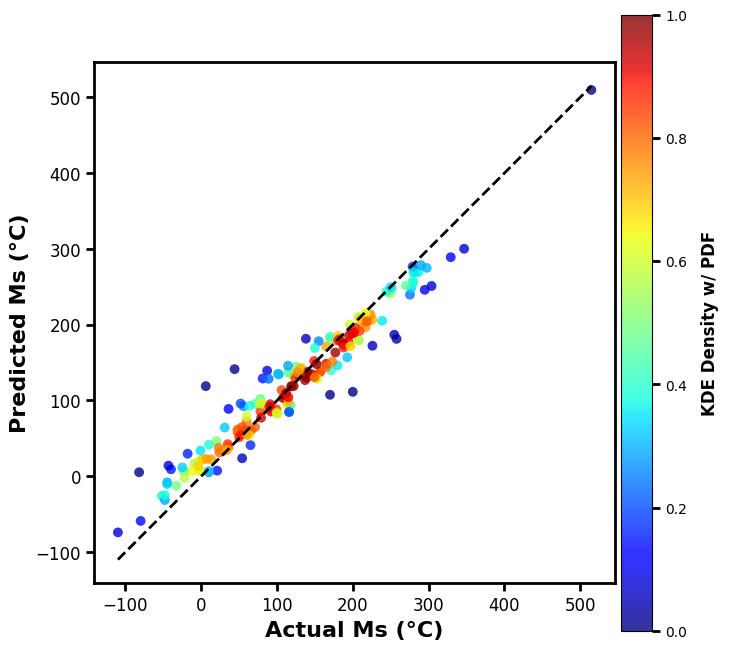

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde

# Assuming y_true, y_pred, ensemble_actuals, ensemble_preds, and data_dir are already defined

# Set plot style to a clean look
plt.style.use('default')  # Reset to default style for a clean look
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
})

# Function to compute KDE density for coloring
def compute_kde_density(x, y):
    # Stack x and y into a single array for KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    # Compute density at each point
    density = kde(xy)
    # Normalize density to [0, 1] for colormap
    density = (density - density.min()) / (density.max() - density.min())
    return density

# Create parity plot for full dataset
fig, ax = plt.subplots(figsize=(8, 8))  # Square plot

# Compute KDE density for coloring
density = compute_kde_density(y_true.flatten(), y_pred.flatten())

# Scatter plot with KDE-based coloring (red to blue colormap)
scatter = ax.scatter(y_true, y_pred, c=density, cmap='jet', s=50, alpha=0.8, edgecolors='none')

# Add diagonal line
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_label('KDE Density w/ PDF', fontsize=12, labelpad=10)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=10)

# Set labels and title
ax.set_xlabel('Actual Ms (°C)')
ax.set_ylabel('Predicted Ms (°C)')
# ax.set_title('(a)', loc='left', fontsize=18, pad=10)

# Set axis limits based on data (unchanged from original)
# ax.set_xlim(y_true.min(), y_true.max())
# ax.set_ylim(y_true.min(), y_true.max())
ax.set_aspect('equal', adjustable='box')

# Customize ticks and spines
ax.tick_params(axis='both', which='major', labelsize=12)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Remove grid
ax.grid(False)

# Save the plot
plt.savefig(os.path.join(data_dir, 'parity_plot_full.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create parity plot for ensemble
fig, ax = plt.subplots(figsize=(8, 8))

# Compute KDE density for coloring
density = compute_kde_density(ensemble_actuals.flatten(), ensemble_preds.flatten())

# Scatter plot with KDE-based coloring (red to blue colormap)
scatter = ax.scatter(ensemble_actuals, ensemble_preds, c=density, cmap='jet', s=50, alpha=0.8, edgecolors='none')

# Add diagonal line
ax.plot([ensemble_actuals.min(), ensemble_actuals.max()], [ensemble_actuals.min(), ensemble_actuals.max()], 'k--', lw=2)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_label('KDE Density w/ PDF', fontsize=12, labelpad=10)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=10)

# Set labels and title
ax.set_xlabel('Actual Ms (°C)')
ax.set_ylabel('Predicted Ms (°C)')
# ax.set_title('(a)', loc='left', fontsize=18, pad=10)

# Set axis limits based on data (unchanged from original)
# ax.set_xlim(ensemble_actuals.min(), ensemble_actuals.max())
# ax.set_ylim(ensemble_actuals.min(), ensemble_actuals.max())
ax.set_aspect('equal', adjustable='box')

# Customize ticks and spines
ax.tick_params(axis='both', which='major', labelsize=12)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Remove grid
ax.grid(False)

# Save the plot
plt.savefig(os.path.join(data_dir, 'parity_plot_ensemble.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
# Select features for attention branch (compositional features)
attention_features = ['Ni', 'Ti', 'Hf', 'Zr', 'Cu', 'Pd', 'Co', 'Nb']
attention_indices = [X.columns.get_loc(col) for col in attention_features]
X_attention = X_scaled_df.iloc[:, attention_indices].values

# Wrapper class to handle dual inputs for SHAP
class DeepFusionWrapper(torch.nn.Module):
    def __init__(self, model):
        super(DeepFusionWrapper, self).__init__()
        self.model = model

    def forward(self, inputs):
        # Inputs: [dense_inputs, attention_inputs]
        dense_inputs = inputs[:, :input_dim]
        attention_inputs = inputs[:, input_dim:input_dim + attention_input_dim]
        return self.model(dense_inputs, attention_inputs)

# Create wrapper model
wrapper_model = DeepFusionWrapper(model).to(device)

# Prepare data for SHAP
X_shap = np.hstack((X_scaled_df.values, X_attention))
feature_names = list(X_scaled_df.columns) + [f"{feat}_attn" for feat in attention_features]

# Convert to PyTorch tensors
X_shap_tensor = torch.tensor(X_shap, dtype=torch.float32).to(device)

# Select a background dataset (e.g., 100 samples) for SHAP
background_idx = np.random.choice(X_shap.shape[0], 100, replace=False)
background = X_shap[background_idx]
background_tensor = torch.tensor(background, dtype=torch.float32).to(device)

# Initialize SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapper_model, background_tensor)

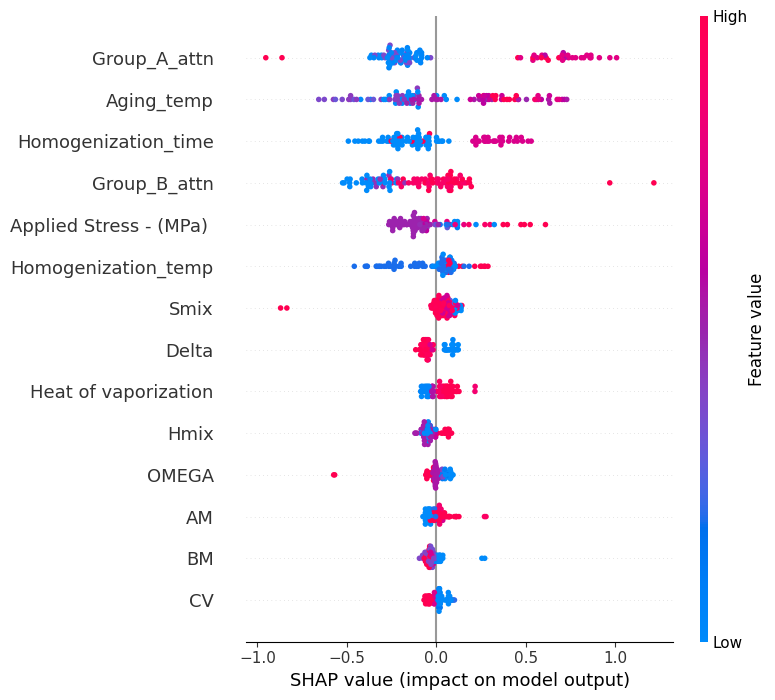

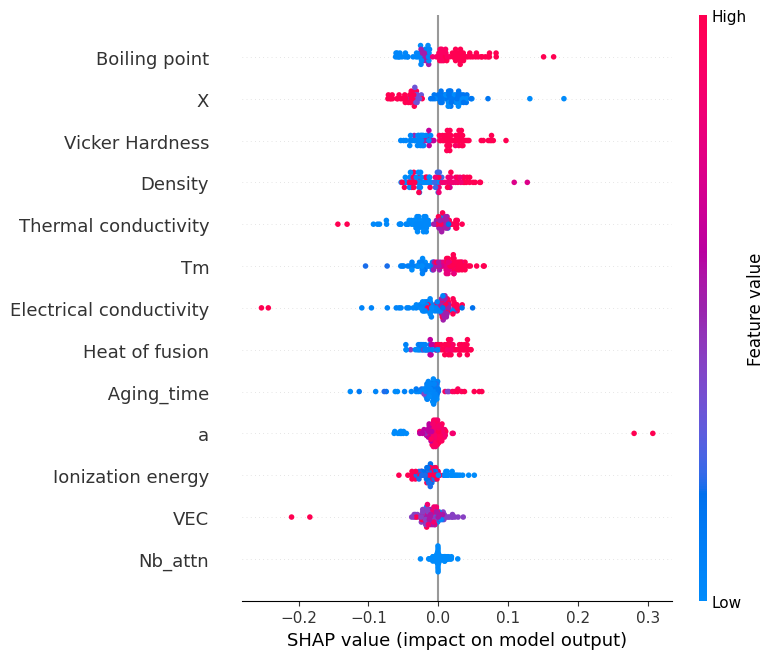

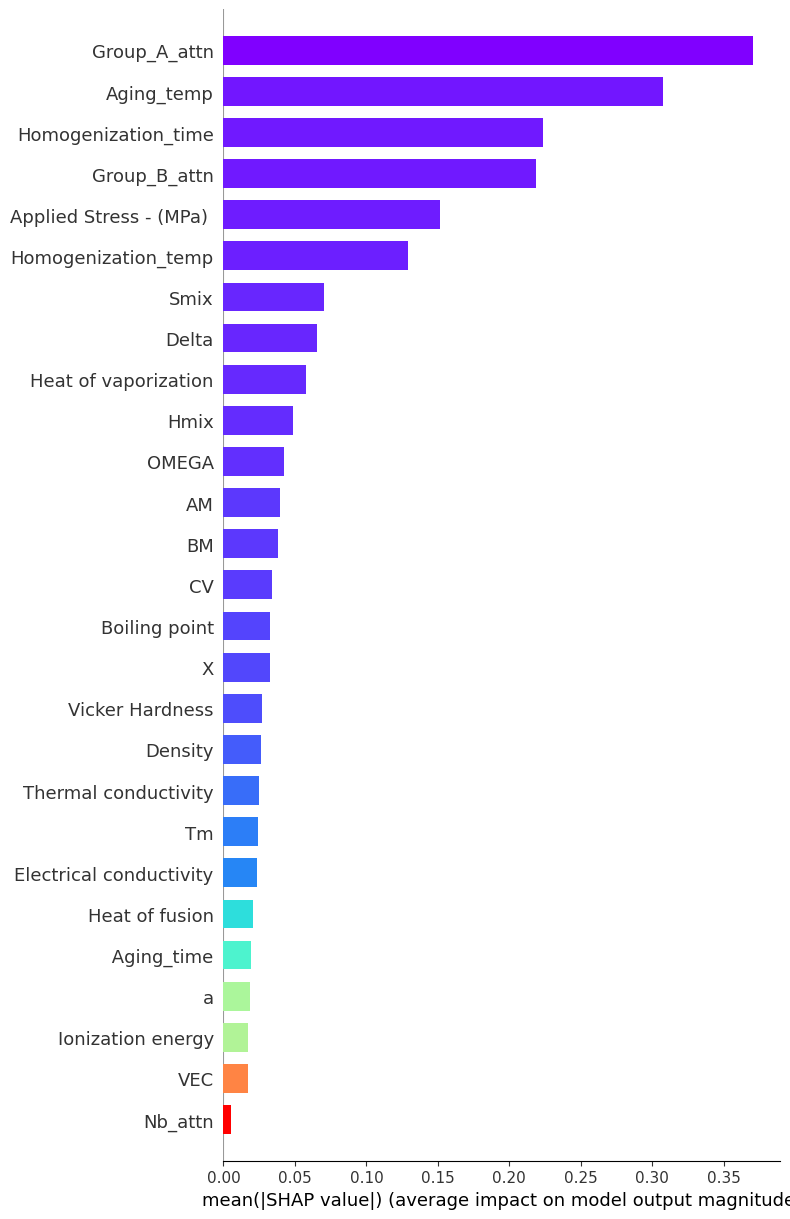

Mean Absolute SHAP Values (sorted by importance):
Group_A_attn: 0.371
Aging_temp: 0.308
Homogenization_time: 0.223
Group_B_attn: 0.219
Applied Stress - (MPa) : 0.152
Homogenization_temp: 0.129
Smix: 0.070
Delta: 0.066
Heat of vaporization: 0.058
Hmix: 0.049
OMEGA: 0.042
AM: 0.040
BM: 0.038
CV: 0.034
Boiling point: 0.032
X: 0.032
Vicker Hardness: 0.027
Density: 0.026
Thermal conductivity: 0.025
Tm: 0.024
Electrical conductivity: 0.023
Heat of fusion: 0.021
 Aging_time: 0.019
a: 0.018
Ionization energy: 0.017
VEC: 0.017
Nb_attn: 0.006


/tmp/ipykernel_1877794/3165297925.py:129: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


In [29]:
# Compute SHAP values for a subset of the data (e.g., first 100 samples)
X_test_shap = X_shap[:100]
X_test_shap_tensor = torch.tensor(X_test_shap, dtype=torch.float32).to(device)
shap_values = explainer.shap_values(X_test_shap_tensor)

# Convert SHAP values to NumPy array if they are a tensor or list
if isinstance(shap_values, torch.Tensor):
    shap_values = shap_values.cpu().numpy()
elif isinstance(shap_values, list):
    shap_values = np.array(shap_values)

# Ensure shap_values is 2D (samples x features)
if shap_values.ndim == 3:
    shap_values = shap_values.squeeze()
elif shap_values.ndim == 1:
    shap_values = shap_values.reshape(-1, X_test_shap.shape[1])

# Compute expected value manually for GradientExplainer
with torch.no_grad():
    background_outputs = wrapper_model(background_tensor)
    expected_value = background_outputs.mean().cpu().numpy().item()

# Group Homogenization_temp and Homogenization_time features
# Identify indices of one-hot encoded features
homogenization_temp_indices = [i for i, name in enumerate(feature_names) if name.startswith('Homogenization_temp_')]
homogenization_time_indices = [i for i, name in enumerate(feature_names) if name.startswith('Homogenization_time_')]

# Sum SHAP values for each group
homogenization_temp_shap = shap_values[:, homogenization_temp_indices].sum(axis=1, keepdims=True)
homogenization_time_shap = shap_values[:, homogenization_time_indices].sum(axis=1, keepdims=True)

# Identify indices of individual compositional features to remove (Ni, Ti, Hf, Zr, Cu, Pd, Co, Nb)
features_to_remove = ['Ni', 'Ti', 'Hf', 'Zr', 'Cu', 'Pd', 'Co', 'Nb']
remove_indices = [i for i, name in enumerate(feature_names) if name in features_to_remove]

# Group _attn features into Group_A_attn (Ni_attn, Pd_attn, Cu_attn, Co_attn) and Group_B_attn (Ti_attn, Hf_attn, Zr_attn)
group_a_attn_indices = [i for i, name in enumerate(feature_names) if name in ['Ni_attn', 'Pd_attn', 'Cu_attn', 'Co_attn']]
group_b_attn_indices = [i for i, name in enumerate(feature_names) if name in ['Ti_attn', 'Hf_attn', 'Zr_attn']]
nb_attn_indices = [i for i, name in enumerate(feature_names) if name == 'Nb_attn']

# Sum SHAP values for each _attn group
group_a_attn_shap = shap_values[:, group_a_attn_indices].sum(axis=1, keepdims=True)
group_b_attn_shap = shap_values[:, group_b_attn_indices].sum(axis=1, keepdims=True)
nb_attn_shap = shap_values[:, nb_attn_indices]  # Keep Nb_attn separate

# Keep indices of features that are not one-hot encoded Homogenization features, not in remove_indices, and not in _attn groups to be combined
other_indices = [i for i in range(len(feature_names)) if i not in homogenization_temp_indices 
                 and i not in homogenization_time_indices 
                 and i not in remove_indices 
                 and i not in group_a_attn_indices 
                 and i not in group_b_attn_indices 
                 and i not in nb_attn_indices]

# Create new SHAP values array by excluding the one-hot features, individual compositional features, individual _attn features, and adding the grouped features
shap_values_grouped = np.hstack([
    shap_values[:, other_indices],  # Keep non-homogenization, non-removed, non-grouped _attn features
    group_a_attn_shap,             # Add grouped Group_A_attn
    group_b_attn_shap,             # Add grouped Group_B_attn
    nb_attn_shap,                  # Add Nb_attn
    homogenization_temp_shap,      # Add grouped Homogenization_temp
    homogenization_time_shap       # Add grouped Homogenization_time
])

# Update feature names
feature_names_grouped = [feature_names[i] for i in other_indices] + ['Group_A_attn', 'Group_B_attn', 'Nb_attn', 'Homogenization_temp', 'Homogenization_time']

# Update X_test_shap to match the new feature set (for plotting)
X_test_shap_grouped = np.hstack([
    X_test_shap[:, other_indices],
    X_test_shap[:, group_a_attn_indices].sum(axis=1, keepdims=True),
    X_test_shap[:, group_b_attn_indices].sum(axis=1, keepdims=True),
    X_test_shap[:, nb_attn_indices],
    X_test_shap[:, homogenization_temp_indices].sum(axis=1, keepdims=True),
    X_test_shap[:, homogenization_time_indices].sum(axis=1, keepdims=True)
])

# Save SHAP plots
output_dir = '/home1/nhuynh2023/Projects/Material_AF/data/Ms/shap_analysis'
os.makedirs(output_dir, exist_ok=True)

# Compute mean absolute SHAP values for ranking features
mean_abs_shap = np.abs(shap_values_grouped).mean(axis=0)
feature_ranking = np.argsort(mean_abs_shap)[::-1]  # Sort in descending order
num_features = len(feature_names_grouped)
half_num = (num_features + 1) // 2  # Split features into two groups (ceiling division)

# Split features into two groups: top half and bottom half
top_half_indices = feature_ranking[:half_num]
bottom_half_indices = feature_ranking[half_num:]

# Prepare data for the two plots
top_half_features = [feature_names_grouped[i] for i in top_half_indices]
bottom_half_features = [feature_names_grouped[i] for i in bottom_half_indices]
shap_values_top = shap_values_grouped[:, top_half_indices]
shap_values_bottom = shap_values_grouped[:, bottom_half_indices]
X_test_shap_top = X_test_shap_grouped[:, top_half_indices]
X_test_shap_bottom = X_test_shap_grouped[:, bottom_half_indices]

# Summary Plot (Top Half Features - Figure 9a)
plt.figure(figsize=(10, half_num * 0.5))  # Adjust height based on number of features
shap.summary_plot(shap_values_top, X_test_shap_top, feature_names=top_half_features, 
                  max_display=len(top_half_features), show=True)
plt.title('SHAP Summary Plot: Top Features for Ms Prediction (a)')
plt.savefig(os.path.join(output_dir, 'shap_summary_plot_grouped_part_a.png'))
plt.close()

# Summary Plot (Bottom Half Features - Figure 9b)
plt.figure(figsize=(10, (num_features - half_num) * 0.5))  # Adjust height based on number of features
shap.summary_plot(shap_values_bottom, X_test_shap_bottom, feature_names=bottom_half_features, 
                  max_display=len(bottom_half_features), show=True)
plt.title('SHAP Summary Plot: Remaining Features for Ms Prediction (b)')
plt.savefig(os.path.join(output_dir, 'shap_summary_plot_grouped_part_b.png'))
plt.close()

# Bar Plot (Mean Absolute SHAP Values - Figure 10) with jet colormap
# Use the jet colormap (red for high values, blue for low values)
cmap = plt.get_cmap('rainbow')
# Normalize the mean absolute SHAP values to map to the colormap
norm = plt.Normalize(min(mean_abs_shap), max(mean_abs_shap))
colors = [cmap(norm(value)) for value in mean_abs_shap[feature_ranking]]

# Generate the bar plot with custom colors
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_grouped, X_test_shap_grouped, feature_names=feature_names_grouped, 
                  plot_type="bar", show=True, color=colors, max_display=len(feature_names_grouped))
plt.title('SHAP Bar Plot: Mean Absolute Feature Importance')
# Add a colorbar to indicate the mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Mean Absolute SHAP Value', rotation=270, labelpad=15)
plt.savefig(os.path.join(output_dir, 'shap_bar_plot_grouped.png'))
plt.close()

# Print the mean absolute SHAP values for each feature, sorted by importance
print("Mean Absolute SHAP Values (sorted by importance):")
for idx in feature_ranking:
    feature_name = feature_names_grouped[idx]
    shap_value = mean_abs_shap[idx]
    print(f"{feature_name}: {shap_value:.3f}")


In [32]:
# Function to plot error histogram and cumulative histogram
def plot_error_histogram(errors, mae, title, filename, output_dir):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # Define custom bin edges
    bin_edges = np.concatenate(([0, 10], np.arange(15, 105, 5)))
    x_ticks = np.concatenate(([0, 10], np.arange(15, 105, 5)))
    
    # Plot histogram
    n, bins, patches = ax1.hist(errors, bins=bin_edges, color='#0343df', 
                                alpha=0.5, edgecolor='black', rwidth=0.8, label='Error Distribution')
    
    # Annotate bars with counts
    for rect in patches:
        height = rect.get_height()
        if height > 0:
            ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{int(height)}', 
                     ha='center', va='bottom', color='purple', fontweight='bold', fontsize=12)
    
    # Plot cumulative histogram
    n_cumulative = np.cumsum(n)
    ax2 = ax1.twinx()
    bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2
    ax2.plot(bin_centers, n_cumulative, color='r', marker='o', linestyle='-', label='Cumulative Count')
    
    # Plot MAE line
    ax1.axvline(mae, color='green', linestyle='--', label=f'MAE°C')
    
    # Set labels and styles
    ax1.set_xlabel('Prediction Error (°C)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Count', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Cumulative Count', fontweight='bold', fontsize=14)
    
    ax1.set_xticks(x_ticks)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, ax1.get_ylim()[1] + 5)
    ax1.grid(False, axis='y')
    
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
    for spine in ax2.spines.values():
        spine.set_linewidth(2)
    ax1.tick_params(axis='both', width=2, length=6, labelsize=14)
    ax2.tick_params(axis='both', width=2, length=6, labelsize=14)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
    
    plt.title(title, fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()
    plt.close()

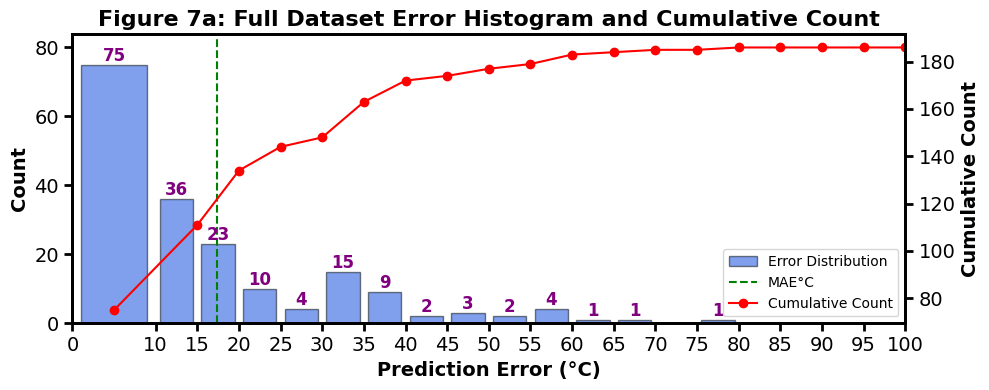

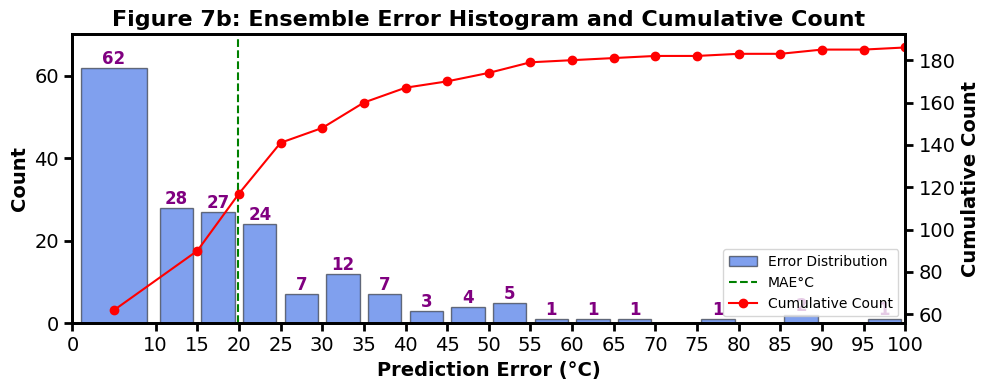

In [33]:
ensemble_preds = np.mean(test_predictions, axis=0)
ensemble_actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1))

ensemble_test_mae = mean_absolute_error(ensemble_actuals, ensemble_preds)

# Calculate absolute errors for histograms
errors_full = np.abs(y_pred - y_true).flatten()
errors_ensemble = np.abs(ensemble_preds - ensemble_actuals).flatten()

# Generate error histograms for Figure 7
plot_error_histogram(
    errors=errors_full, 
    mae=test_mae, 
    title='Figure 7a: Full Dataset Error Histogram and Cumulative Count',
    filename='figure_7a_error_histogram_full.png',
    output_dir=data_dir
)

plot_error_histogram(
    errors=errors_ensemble, 
    mae=ensemble_test_mae, 
    title='Figure 7b: Ensemble Error Histogram and Cumulative Count',
    filename='figure_7b_error_histogram_ensemble.png',
    output_dir=data_dir
)